In [1]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import math


import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping


In [2]:
driver_details = pd.read_csv('driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [3]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("C:\\Users\\zouhri\\a\\PFA\\imgs\\train/c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "C:\\Users\\zouhri\\a\\PFA\\imgs\\train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [4]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

In [5]:
## getting list of driver names

D = []
for features,labels,drivers in train_image:
    D.append(drivers)

## Deduplicating drivers

deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)
    

## selecting random drivers for the validation set
driv_selected = []
import random
driv_nums = random.sample(range(len(deduped)), 4)
for i in driv_nums:
    driv_selected.append(deduped[i])


In [6]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

19473 2951
19473 2951


In [14]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)


(19473, 224, 224, 3)


In [15]:
## Defining the input

from keras.layers import Input
resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50


#Get the RESNET weights and layers

model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_resnet50_conv.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
#Use the generated model 
from keras.models import Model


output_resnet50_conv = model_resnet50_conv(resnet50_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_resnet50_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)


resnet50_pretrained = Model( resnet50_input,  x)


## Stratégie #2 : extraction de features
#On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :

'''for layer in resnet50_pretrained.layers:
   layer.trainable = False'''

# Ne pas entraîner les 5 premières couches (les plus basses) 
for layer in  resnet50_pretrained.layers[:5]:
   layer.trainable = False


resnet50_pretrained.summary()

# Compile CNN model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)



def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
        math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)




resnet50_pretrained.compile(loss='binary_crossentropy',optimizer = 'adam',metrics=['accuracy','AUC','Precision'])
callbacks = [EarlyStopping(monitor='val_accuracy',patience=4)]

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              411045888 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 10)                40970     
Total params: 451,455,882
Trainable params: 40,970
Non-trainable params: 451,414,912
___________________________________

In [17]:
print (X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape).

(2951, 224, 224, 3)
(2951, 10)
(19473, 224, 224, 3)
(19473, 10)


In [18]:
results = resnet50_pretrained.fit(X_train,y_train,batch_size=32,epochs=8,verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)


Epoch 1/8
609/609 [==============================] - 4156s 7s/step - loss: 0.0585 - accuracy: 0.8957 - auc: 0.9884 - precision: 0.9423 - val_loss: 0.1686 - val_accuracy: 0.6598 - val_auc: 0.9363 - val_precision: 0.7229
Epoch 2/8
609/609 [==============================] - 2034s 3s/step - loss: 0.0079 - accuracy: 0.9894 - auc: 0.9995 - precision: 0.9922 - val_loss: 0.2354 - val_accuracy: 0.5707 - val_auc: 0.9171 - val_precision: 0.5899
Epoch 3/8
609/609 [==============================] - 2036s 3s/step - loss: 0.0033 - accuracy: 0.9964 - auc: 0.9999 - precision: 0.9972 - val_loss: 0.1993 - val_accuracy: 0.6435 - val_auc: 0.9319 - val_precision: 0.6774
Epoch 4/8
609/609 [==============================] - 2020s 3s/step - loss: 0.0017 - accuracy: 0.9983 - auc: 0.9999 - precision: 0.9986 - val_loss: 0.2018 - val_accuracy: 0.6801 - val_auc: 0.9306 - val_precision: 0.7116
Epoch 5/8
609/609 [==============================] - 8456s 14s/step - loss: 0.0019 - accuracy: 0.9974 - auc: 1.0000 - precis

In [33]:
evaluation = resnet50_pretrained.evaluate(X_test, y_test)
print('Test Accuracy : {:.3f}'.format(evaluation[1]))
# get the predictions for the test data


93/93 [==============================] - 317s 3s/step - loss: 0.3220 - accuracy: 0.6384 - auc: 0.8986 - precision: 0.6478
Test Accuracy : 0.638


AttributeError: 'Functional' object has no attribute 'predict_classes'

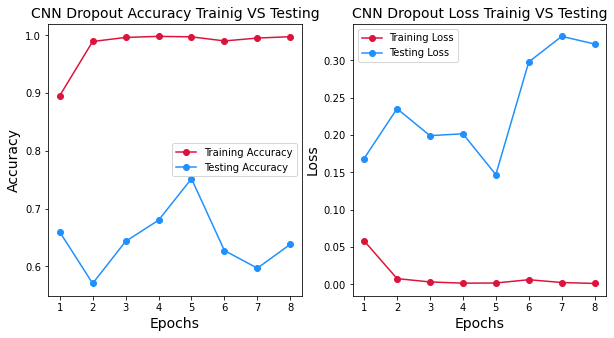

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(resnet50_pretrained.history.history['accuracy']) + 1), resnet50_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(resnet50_pretrained.history.history['val_accuracy']) + 1), resnet50_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['loss']) + 1), resnet50_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['val_loss']) + 1), resnet50_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [20]:
resnet50_pretrained.history.history['accuracy'][:5]

[0.8956503868103027,
 0.9894212484359741,
 0.996405303478241,
 0.9983053207397461,
 0.9974323511123657]

In [52]:
resnet50_pretrained.save_weights('./resnet50_10224.h5', overwrite=True)
resnet50_pretrained.save('./resnet50_10224.h5')

In [69]:
test_directory = 'C:\\Users\\zouhri\\a\\PFA\\imgs2\\test'

In [72]:
# Creating a test dataset.
testing_data = []
i = 0
def create_testing_data():        
    for img in os.listdir(test_directory):
        img_array = cv2.imread(os.path.join(test_directory,img),cv2.IMREAD_COLOR)
        RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_img = cv2.resize(RGB_img ,(224,224))
        testing_data.append([new_img])

In [73]:
create_testing_data()
print(len(testing_data))

1377


In [74]:
import tensorflow as tf
test = []

for img in testing_data:
    test.append(img)
    
model = tf.keras.models.load_model('./resnet50_10224.h5')


test = np.array(test).reshape(-1,224,224,3)
prediction = model.predict(test)

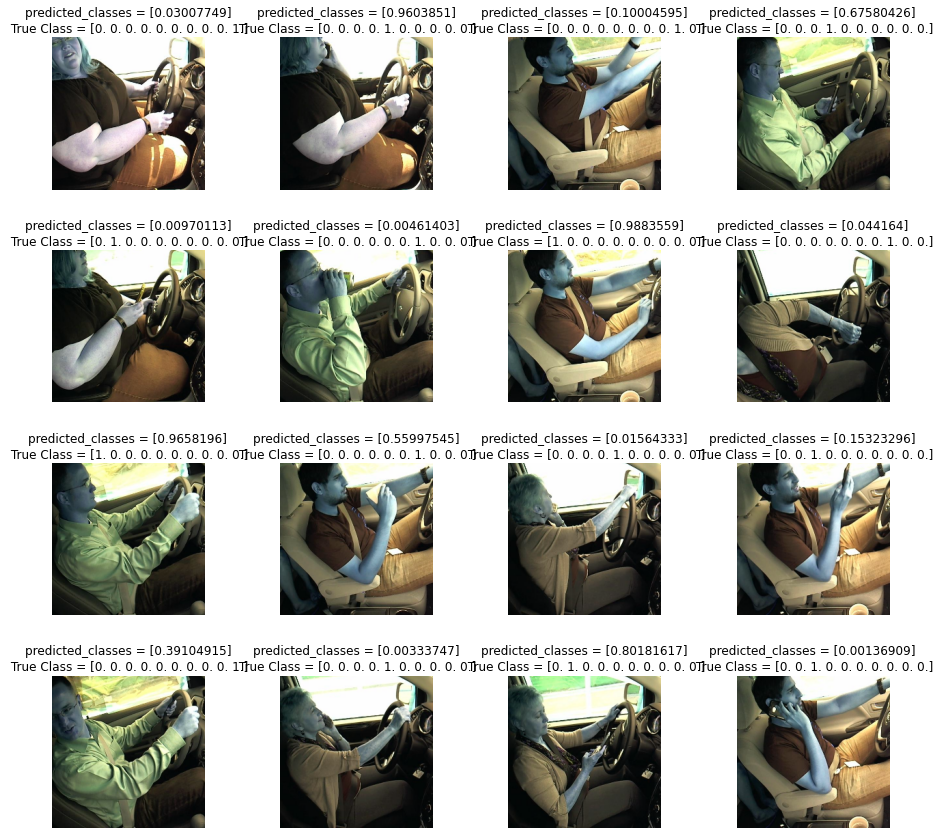

In [27]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title("predicted_classes = {}\n True Class = {}".format(prediction[i], y_test[i]))
    axes[i].axis('off')
    
plt.subplots_adjust(wspace=0.5)


# axes[i].set_title("Guess{}\n True{}".format(predicted_class[i], y_test[i]))

In [75]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


In [76]:
def plot_test_class(model, test, image_number, color_type=3):
    img_brute = test[image_number]
    img_brute = cv2.resize(img_brute,(224,224))
    plt.imshow(img_brute,)

    new_img = img_brute.reshape(-1,224,224,color_type)

    y_prediction = model.predict(new_img, batch_size=32, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

1/1 [==============================] - 0s 3ms/step
Y prediction: [[7.5432062e-08 1.4341782e-01 2.4938567e-02 6.0217917e-06 4.3286438e-04
  8.3626619e-06 2.4773853e-03 5.1565534e-01 3.1524383e-02 2.8153920e-01]]
Predicted: Reaching behind


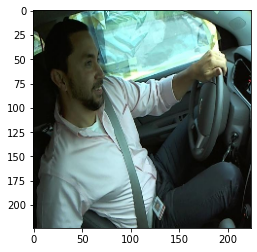

1/1 [==============================] - 0s 14ms/step
Y prediction: [[3.2907983e-09 1.1924377e-08 9.9815661e-01 6.9892786e-11 1.7806506e-06
  7.1005871e-08 1.4382893e-05 8.3475200e-08 1.8265973e-03 3.0778429e-07]]
Predicted: Talking on the phone - right


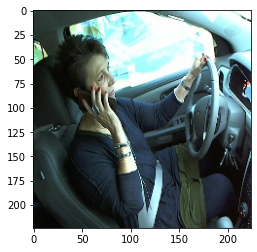

1/1 [==============================] - 0s 7ms/step
Y prediction: [[2.01231698e-09 6.27901114e-04 4.43711400e-01 4.99960606e-09
  7.70746283e-07 1.13047577e-06 2.37362022e-11 1.50729818e-07
  5.55644095e-01 1.45394615e-05]]
Predicted: Hair and makeup


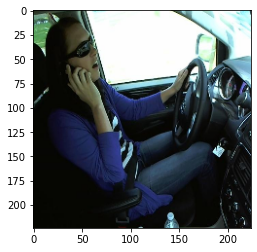

1/1 [==============================] - 0s 5ms/step
Y prediction: [[9.5884952e-06 1.4697220e-07 5.8750552e-03 3.3271706e-07 1.3738811e-01
  4.8708290e-01 2.3887704e-05 9.0187452e-05 3.6944708e-01 8.2694540e-05]]
Predicted: Operating the radio


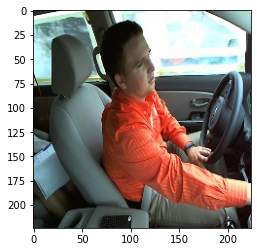

1/1 [==============================] - 0s 6ms/step
Y prediction: [[1.3181408e-07 1.0357581e-03 7.4585387e-03 4.9149463e-08 2.8584260e-05
  1.2907482e-04 2.0796007e-03 1.5475231e-02 9.7377282e-01 2.0146457e-05]]
Predicted: Hair and makeup


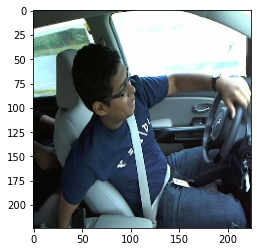

1/1 [==============================] - 0s 3ms/step
Y prediction: [[7.0297872e-08 1.6772635e-02 5.6181394e-05 1.8502107e-06 2.2772580e-05
  3.1960036e-07 1.2157821e-05 5.7585491e-03 9.7727990e-01 9.5562122e-05]]
Predicted: Hair and makeup


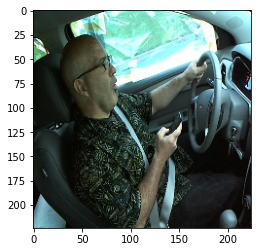

1/1 [==============================] - 0s 2ms/step
Y prediction: [[1.6163222e-05 3.9855597e-04 1.2106013e-01 1.0487475e-06 7.1191406e-01
  2.8567730e-02 1.3313596e-07 5.0468352e-03 2.0967002e-03 1.3089852e-01]]
Predicted: Talking on the phone - left


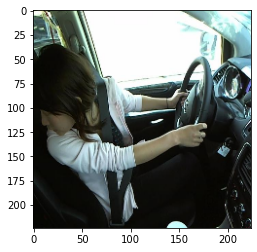

1/1 [==============================] - 0s 6ms/step
Y prediction: [[1.5990195e-10 2.7314582e-05 4.8554862e-01 3.1934404e-09 4.1278192e-10
  9.3210051e-11 1.0791978e-09 5.4618997e-08 5.1442176e-01 2.2472379e-06]]
Predicted: Hair and makeup


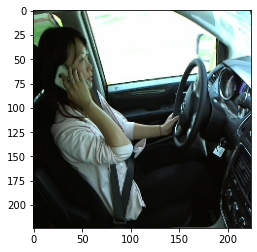

1/1 [==============================] - 0s 4ms/step
Y prediction: [[8.8471334e-11 3.2323706e-07 1.5448279e-09 6.9822359e-10 2.7948309e-13
  1.0060002e-09 4.8053696e-08 9.4312787e-11 9.9999964e-01 1.3289990e-10]]
Predicted: Hair and makeup


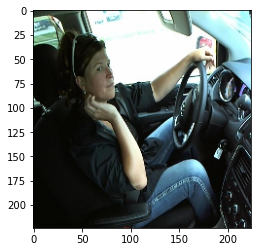

1/1 [==============================] - 0s 5ms/step
Y prediction: [[9.2284461e-07 8.4253699e-01 2.3414954e-05 1.8394257e-06 1.3701178e-08
  2.2527165e-04 5.0865661e-04 2.5879536e-03 1.5405723e-01 5.7812082e-05]]
Predicted: Texting - right


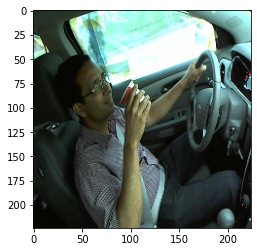

In [91]:
for i in range(10):
    plot_test_class(model, test, i)
